<a href="https://colab.research.google.com/github/NehaAgg245/ML-git/blob/master/24hr_load_weather.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
from google.colab import files
uploaded = files.upload()

Saving UTDWeather_load_v1.csv to UTDWeather_load_v1 (1).csv


In [11]:
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
import pandas as pd
import io
import numpy as np
from datetime import datetime

#Import Data
def parse(x):
	return datetime.strptime(x, '%Y %m %d %H')

weather_data = pd.read_csv(io.StringIO(uploaded['UTDWeather_load_v1.csv'].decode('utf-8')),parse_dates = [['Year', 'Month', 'Day', 'Hour']], index_col = 0, date_parser = parse)
weather_data.index.name = 'Date'
print(weather_data.head())


                     DHI  DNI  GHI  Clearsky DHI  Clearsky DNI  Clearsky GHI  \
Date                                                                           
2014-01-01 00:00:00    0    0    0             0             0             0   
2014-01-01 01:00:00    0    0    0             0             0             0   
2014-01-01 02:00:00    0    0    0             0             0             0   
2014-01-01 03:00:00    0    0    0             0             0             0   
2014-01-01 04:00:00    0    0    0             0             0             0   

                     Cloud Type  Dew Point  Temperature     Pressure  \
Date                                                                   
2014-01-01 00:00:00           0  -1.259314     1.801935  1001.034851   
2014-01-01 01:00:00           0  -1.251990     1.385065  1000.495544   
2014-01-01 02:00:00           0  -1.258856     1.022241   999.998657   
2014-01-01 03:00:00           0  -1.260016     0.723383   999.362183   
2014-01

In [16]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE

X = weather_data.values[:,0:-1]
y = weather_data.values[:,-1]

estimator = RandomForestRegressor(n_estimators=500, random_state=1)
selector = RFE(estimator)
rfe = selector.fit(X, y) 
rfe.ranking_

array([6, 7, 8, 4, 3, 9, 5, 1, 1, 1, 2, 1, 1, 1, 1])

In [12]:
weather_data.drop(weather_data.columns[[0,1,2,3,4,5,6,10]],axis = 1, inplace = True)
print(weather_data.head())

                     Dew Point  Temperature     Pressure  Solar Zenith Angle  \
Date                                                                           
2014-01-01 00:00:00  -1.259314     1.801935  1001.034851          170.031382   
2014-01-01 01:00:00  -1.251990     1.385065  1000.495544          163.526765   
2014-01-01 02:00:00  -1.258856     1.022241   999.998657          151.905377   
2014-01-01 03:00:00  -1.260016     0.723383   999.362183          139.445120   
2014-01-01 04:00:00  -1.236578     0.513696   998.875122          126.878538   

                     Precipitable Water  Wind Direction  Wind Speed     Load  
Date                                                                          
2014-01-01 00:00:00            7.929036      184.148132    4.299884  1721.29  
2014-01-01 01:00:00            8.305254      186.851776    4.334047  1721.29  
2014-01-01 02:00:00            8.708726      188.751770    4.403373  1711.40  
2014-01-01 03:00:00            9.254774     

In [0]:
from numpy import split
def split_dataset(data):
  n_train_hours = 365 * 24
  train, test = data[:n_train_hours, :], data[-n_train_hours :-24]
  
  train = array(split(train, len(train)/24))
  test = array(split(test, len(test)/24))
  return train, test


In [0]:
# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
	scores = list()
	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		# calculate rmse
		rmse = sqrt(mse)
		# store
		scores.append(rmse)
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores


In [0]:
# convert history into inputs and outputs
def to_supervised(train, n_input, n_out=24):
	# flatten data
	data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
	X, y = list(), list()
	in_start = 0
	# step over the entire history one time step at a time
	for _ in range(len(data)):
		# define the end of the input sequence
		in_end = in_start + n_input
		out_end = in_end + n_out
		# ensure we have enough data for this instance
		if out_end < len(data):
			X.append(data[in_start:in_end, :])
			y.append(data[in_end:out_end, 0])
		# move along one time step
		in_start += 1
	return array(X), array(y)

In [0]:
# summarize scores
def summarize_scores(name, score, scores):
	s_scores = ', '.join(['%.1f' % s for s in scores])
	print('%s: [%.3f] %s' % (name, score, s_scores))


In [0]:
from keras import backend as K
i=0
def pinball(y_true, y_pred):
    global i
    tao = (i + 1) / 10
    pin = K.mean(K.maximum(y_true - y_pred, 0) * tao +
                 K.maximum(y_pred - y_true, 0) * (1 - tao))
    return pin

In [0]:

# train the model
def build_model(train, n_input):
	# prepare data
	train_x, train_y = to_supervised(train, n_input)
	# define parameters
	verbose, epochs, batch_size = 0, 70, 6 #Try verbose 2 also
	n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
	# define model
	model = Sequential()
	model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
	model.add(Dense(100, activation='relu'))
	model.add(Dense(n_outputs))
	model.compile(loss=pinball, optimizer='adam')
	# fit network
	model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
	return model

In [0]:
# make a forecast
def forecast(model, history, n_input):
	# flatten data
	data = array(history)
	data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
	# retrieve last observations for input data
	input_x = data[-n_input:, :]
	# reshape into [1, n_input, n]
	input_x = input_x.reshape((1, input_x.shape[0], input_x.shape[1]))
	# forecast the next week
	yhat = model.predict(input_x, verbose=0)
	# we only want the vector forecast
	yhat = yhat[0]
	return yhat

In [0]:
# evaluate a single model
def evaluate_model(train, test, n_input):
	# fit model
	model = build_model(train, n_input)
	# history is a list of weekly data
	history = [x for x in train]
	# walk-forward validation over each week
	predictions = list()
	for i in range(len(test)):
		# predict the week
		yhat_sequence = forecast(model, history, n_input)
		# store the predictions
		predictions.append(yhat_sequence)
		# get real observation and add to history for predicting the next week
		history.append(test[i, :])
	# evaluate predictions days for each week
	predictions = array(predictions)
	score, scores = evaluate_forecasts(test[:, :, 0], predictions)
	return score, scores

(365, 24, 8)
lstm: [21.022] 15.9, 16.1, 16.2, 16.4, 16.5, 16.1, 14.6, 14.3, 17.5, 21.9, 25.5, 28.2, 30.0, 30.9, 30.8, 29.1, 25.6, 21.3, 18.0, 16.6, 16.1, 16.0, 16.0, 15.9


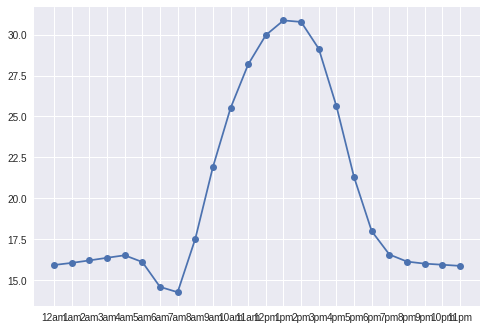

In [33]:
train , test = split_dataset(weather_data.values)
print(train.shape)
n_input = 24
score, scores = evaluate_model(train, test, n_input)
# summarize scores
summarize_scores('lstm', score, scores)
# plot scores
hrs = ['12am', '1am', '2am', '3am', '4am', '5am', '6am','7am','8am','9am','10am','11am','12pm','1pm','2pm', '3pm', '4pm', '5pm', '6pm','7pm','8pm','9pm','10pm','11pm']
pyplot.plot(hrs, scores, marker='o', label='lstm')
pyplot.show()

In [0]:
-